# Multivariable Calculus Review

#### *18 September 2020*
#### *DATA 1010*

In this notebook, we review some ideas from multivariable calculus which are important for machine learning. 

---

## Multivariable Optimization

Consider the problem of finding the line which minimizes the sum of squared vertical distances between the points shown and the line: 

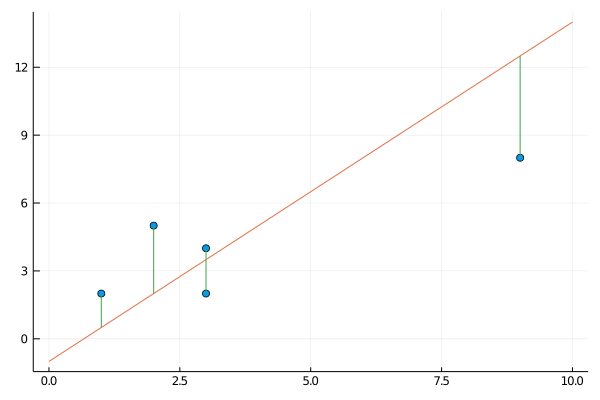

In [7]:
using Plots
A = [3 2; 1 2; 9 8; 3 4; 2 5]
scatter(A[:,1], A[:,2], legend = false)
m, b = 1.5, -1
plot!(0:10, x-> m*x + b)
sticks!(A[:,1], A[:,2], fillrange = m * A[:,1] .+ b) # fillrange is for where to draw the sticks from

We do this by defining a function $L(m,b) = [y_1 - (mx_1 + b)]^2 + \cdots + [y_n - (mx_n + b)]^2$, where $(x_1, y_1), \ldots, (x_n,y_n)$ are the points we're trying to fit. We call $L$ a **loss function**. We search for the values of $m$ and $b$ which minimize $L$. 

Finding a function which best fits a given set of points is a ubiquitious pattern in machine learning, so multivariable optimization plays a prominent role in the subject. Let's begin by reviewing some basics. 

**Theorem**. Suppose $D \subset \mathbb{R}^n$. If a differentiable function $f:D \to \mathbb{R}$ has a local extrememum at a point $\mathbf{x}$, then either: 
* $\mathbf{x}$ is in the interior of $D$ and either $\nabla f(\mathbf{x}) = \mathbf{0}$  or $f$ is nondifferentiable at $\mathbf{x}$, or 
* $\mathbf{x}$ is on the boundary of $D$ and either $\nabla f(\mathbf{x}) = \lambda \nabla g(\mathbf{x})$ for some $\lambda$ (where $g$ is a function whose level set through $\mathbf{x}$ coincides with the of which the boundary of $D$ there), or $\mathbf{x}$ is at a point where the boundary of $D$ is non-smooth (like a corner).

### Problem 1

Find the line of best fit for the points above. The code below might be helpful. You can differentiate a SymPy expressions `f` with respect to `x` using `diff(f, x)`, and you can solve the system $f(x,y) = 0, g(x,y) = 0$ with `sympy.solve((f, g), (x,y))`: 

```julia
julia> sympy.solve((x + y - 5, x - y), (x,y))
x => 5/2
y => 5/2
```

In [8]:
using SymPy
@vars m b
L = sum((y - m*x + b)^2 for (x,y) in eachrow(A))

             2                2                2                2             
(b - 9⋅m + 8)  + (b - 3⋅m + 2)  + (b - 3⋅m + 4)  + (b - 2⋅m + 5)  + (b - m + 2

 2
) 

We can graph the loss function with respect to $m$ and $b$ to get a different perspective on the problem:

In [11]:
plotlyjs()
xs = range(-2, 3, length=10)
ys = range(-2, 2, length=10)
@vars m b
L = sum((y - m*x + b)^2 for (x,y) in eachrow(A))
surface(xs, ys, [L(m=>x,b=>y) for x in xs, y in ys], 
        xlabel = "m", ylabel = "b", zlabel = "L", colorbar = false)

<!DOCTYPE html>
 
 
 Plots.jl

Note that the graph is very valley-like (it has one direction along which the graph increases quite sharply in both directions, and an orthogonal direction where the increase as you move away from the minimum is gradual). We will revisit this point later today.

### Problem 2
The $m$ and $b$ values you found above should satisfy $m^2 + b^2 > 3$. Find the values which minimize $L$ subject to the constraint $m^2 + b^2 \leq 3$. 

Note: `sympy.solve` won't work here because the equation is too hard to solve analytically (actually it will work, but it takes a while, and it gives answers in the form of enormous, unwieldy expressions). You'll need to use `sympy.nsolve`, and that function requires supplying a third argument as a starting point. I suggest `(1,1,1)`. 

## Taylor Series

Multivariable optimization can be a deep and subtle problem. One valuable tool for considering how various optimization algorithms compare is to understand the **second-order** behavior at a local minimum. 

Recall the second-order Taylor polynomial for a function $f$: 

$$
P_2(\mathbf{x}) = f(\mathbf{a}) + \nabla f(\mathbf{a}) \cdot (\mathbf{x}-\mathbf{a}) + \frac{1}{2} (\mathbf{x}-\mathbf{a})'H(\mathbf{a})(\mathbf{x} -\mathbf{a}),
$$

where $H(\mathbf{a})$ is the matrix of second-order partial derivatives of $f$. 

![](taylor.png)


At a local minimum of a differential function, the first-order behavior is always constant (since the gradient is zero). However, the second-order behavior can help us tell whether the function has a local minimum or maximum at the point. 

### Problem 3

Find the quadratic approximation of the $f(x) = e^x - 2x$ at its minimum and graph it to see how it hugs the graph of $f$.

In [12]:
xs = 0:1/100:1
plot(xs, x -> exp(x) - 2x, label="original")
plot!(xs, x -> 2 - 2log(2), ylims = (1/2,1), label = "linear")
#plot!(xs, x -> (fill in a function of x here), label = "quadratic")

<!DOCTYPE html>
 
 
 Plots.jl

For functions of more than one variable, second-order behavior near a critical point is richer than just "min" or "max". The graph can be up-turned in some directions and down-turned in others (like a saddle). And even if it's up-turned in all directions, the relative magnitudes, there's an important difference between graphs like the one below, which form a nice bowl shape, and graphs like the one we saw above with the line-of-best-fit problem, which is more like a valley. 

In [13]:
surface(-5:0.1:5, -5:0.1:5, (x,y) -> x^2 + y^2)

<!DOCTYPE html>
 
 
 Plots.jl

The key to measuring how valley-like vs. bowl-like a function's graph is near a local minimum is the **spectral theorem**. If we eigendecompose the Hessian as $\lambda_1 \mathbf{u}_1\mathbf{u}_1' + \cdots + \lambda_n \mathbf{u}_n\mathbf{u}_n'$, and expand $\mathbf{x} - \mathbf{a}$ with respect to the basis $\{\mathbf{u}_1, \ldots, \mathbf{u}_n\}$ as $c_1\mathbf{u}_1 + \cdots + c_n\mathbf{u}_n$, then then the quadratic term in the Taylor polynomial becomes 
$$
\lambda_1 c_1^2 + \lambda_2 c_2^2 + \cdots + \lambda_n c_n^2. 
$$
In other words, as we move away from the base point $\mathbf{a}$ in the direction of the first eigenector of $H$, the function behaves like the parabola $c_1 \mapsto \lambda_1 c_1^2$ (and similarly for the other eigenvector directions).

Use the cell below to find the eigenvalues of the Hessian for the example above. You might find the function `float` helpful for converting the symbolic expression back to a floating point number. 

Are the numbers you see consistent with the valley-like behavior you observed in the graph above? Explain.

In [14]:
@vars m b
eigvals(hessian(L,(m,b)))

2-element Array{Sym,1}:
 9⋅√137 + 109
 109 - 9⋅√137

### Problem 4 (challenge)

Show that if $\mathbf{x}$ is a local minimum of the constrained minimization problem with objective function $f$ and constraint inequality $g \geq 0$, then $\mathbf{x}$ is a local extremum for the objective function
$$
\mathcal{L}(\mathbf{x}, \lambda)=f(\mathbf{x}) - \lambda g(\mathbf{x})
$$
subject to the constraints
$$
\begin{align*}
g(\mathbf{x}) &\geq 0 \\ 
\lambda &\geq 0 \\
\lambda g(\mathbf{x}) &= 0
\end{align*}
$$

Note: these are called the Karush-Kuhn-Tucker (KKT) conditions, and we'll see them again when we discuss the *support vector machine* classifier.